In [1]:
import wandb
import numpy as np
import os
import random
import glob
import pandas as pd
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import importlib
from common import common
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, VotingClassifier
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
from sklearn.datasets import fetch_openml
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import export_text
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
wandb.login()

wandb: Currently logged in as: brinashong. Use `wandb login --relogin` to force relogin


True

In [23]:
# Reload common module
importlib.reload(common)

<module 'common.common' from '/home/brina/nus-mcomp/sem2/cs5344-big-data-analytics-technology/CS5344_Project.git/master/work/common/common.py'>

In [4]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'

In [5]:
# project name should correspond to dataset below
# project_name = "covertype"
# project_name = "kdd"
# project_name = "cicids"
# project_name = "thyroid"
# project_name = "unsw"
# project_name = "customer"
# project_name = "satellite"
# project_name = "drug"
# project_name = "mba"
# project_name = "tii-ssrc"
# project_name = "cirrhosis"
# project_name = "botnet"
# project_name = "ctu13"
project_name = "heart"

In [9]:
if project_name == "covertype":
    %run datasets/covertype.ipynb
    all_df, main_labels, config = get_processed_covtype_df()
elif project_name == "kdd":
    %run datasets/kdd.ipynb
    all_df, main_labels, config = get_processed_kdd_df()
elif project_name == "cicids":
    %run datasets/cicids.ipynb
    all_df, main_labels, config = get_processed_cicids_df()
elif project_name == "thyroid":
    %run datasets/thyroid.ipynb
    all_df, main_labels, config = get_processed_thyroid_df()
elif project_name == "unsw":
    %run datasets/unsw.ipynb
    all_df, main_labels, config = get_processed_unsw_df()
elif project_name == "customer":
    %run datasets/customer.ipynb
    all_df, main_labels, config = get_processed_customer_df()
elif project_name == "satellite":
    %run datasets/satellite.ipynb
    all_df, main_labels, config = get_processed_satellite_df()
elif project_name == "drug":
    %run datasets/drug.ipynb
    all_df, main_labels, config = get_processed_drug_df()
elif project_name == "mba":
    %run datasets/mba.ipynb
    all_df, main_labels, config = get_processed_mba_df()
elif project_name == "tii-ssrc":
    %run datasets/tii-ssrc.ipynb
    all_df, main_labels, config = get_processed_tii_ssrc_df()
elif project_name == "cirrhosis":
    %run datasets/cirrhosis.ipynb
    all_df, main_labels, config = get_processed_cirrhosis_df()
elif project_name == "botnet":
    %run datasets/botnet.ipynb
    all_df, main_labels, config = get_processed_botnet_df()
elif project_name == "ctu13":
    %run datasets/ctu13.ipynb
    all_df, main_labels, config = get_processed_ctu13_df()
else:
    %run datasets/heart.ipynb
    all_df, main_labels, config = get_processed_heart_df()

Normal class:  0    0
dtype: int64
main_labels Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num', 'sex_Female',
       'sex_Male', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal',
       'cp_typical angina', 'fbs_False', 'fbs_True', 'restecg_lv hypertrophy',
       'restecg_normal', 'restecg_st-t abnormality', 'exang_False',
       'exang_True'],
      dtype='object')
Normal class:  0    0
dtype: int64
main_labels Index(['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'num', 'sex_Female',
       'sex_Male', 'cp_asymptomatic', 'cp_atypical angina', 'cp_non-anginal',
       'cp_typical angina', 'fbs_False', 'fbs_True', 'restecg_lv hypertrophy',
       'restecg_normal', 'restecg_st-t abnormality', 'exang_False',
       'exang_True'],
      dtype='object')


In [10]:
# Should already be one hot encoded and label encoded

TARGET_COLUMN = config['TARGET_COLUMN']
NORMAL_TARGET = config['NORMAL_TARGET']
TARGET_DICT = config['TARGET_DICT']
INV_TARGET_DICT = config['INV_TARGET_DICT']
NUMERICAL_COLUMNS = config['NUMERICAL_COLUMNS']
CATEGORICAL_COLUMNS = config['CATEGORICAL_COLUMNS']
ORDINAL_COLUMNS = config['ORDINAL_COLUMNS']
all_df.head()

,age,trestbps,chol,thalch,oldpeak,num,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_False,fbs_True,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,exang_False,exang_True
0,63,145.0,233.0,150.0,2.3,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,67,160.0,286.0,108.0,1.5,2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,67,120.0,229.0,129.0,2.6,1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,37,130.0,250.0,187.0,3.5,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,41,130.0,204.0,172.0,1.4,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
all_df.shape

(918, 19)

In [12]:
# Create a folder to save the CSVs
common.remove_files_from_directory(OUTPUT_FOLDER)
common.remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [13]:
# Save all data as csv
all_df.to_csv('all_data.csv' ,index = False)

In [14]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(734, 18) (184, 18) (734,) (184,)


In [15]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,age,trestbps,chol,thalch,oldpeak,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_False,fbs_True,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,exang_False,exang_True,num
797,51,132.286047,339.0,137.545665,0.878788,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,3
25,50,120.000000,219.0,158.000000,1.600000,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
84,52,120.000000,325.0,172.000000,0.200000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
10,57,140.000000,192.0,148.000000,0.400000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0
344,40,140.000000,289.0,172.000000,0.878788,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [16]:
# Fit and transform the numeric columns
scaler, X_train_scaled_df = common.standardise(X_train_df, NUMERICAL_COLUMNS)
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
scaler, X_test_scaled_df = common.standardise(X_test_df, NUMERICAL_COLUMNS, scaler=scaler)
# print('X_test_scaled_df', X_test_scaled_df)

In [17]:
X_test_scaled_df.head()

,age,trestbps,chol,thalch,oldpeak,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_False,fbs_True,restecg_lv hypertrophy,restecg_normal,restecg_st-t abnormality,exang_False,exang_True
670,0.574961,-1.232904,-0.115841,-1.712141,-0.399443,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
30,1.653195,0.430317,-0.125287,0.542388,0.729958,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
377,-0.934568,0.430317,-0.408679,-0.604653,-0.399443,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
535,-0.826745,-0.124090,-0.446464,-1.000185,-0.399443,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
809,0.143667,0.002650,-0.011930,0.010227,-0.399443,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [24]:
seconds = time.time()

benign = 2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)
target_index = all_df.columns.get_loc(TARGET_COLUMN)
benign_ratio = 3  # Adjust this ratio as needed
min_benign_samples = 50  # Ensure at least 50 benign samples are always included

# Linear method
for label, name in TARGET_DICT.items():
    if label == NORMAL_TARGET:
        continue  # Skip the normal target
    
    # common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    common.get_dataset_for_label(label, name, target_index, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
    
# Parallel execution to create the anomaly datasets for each anomaly class
# def create_dataset(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels):
#     return common.create_dataset_for_label(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)

# # Using Joblib to parallelize the dataset creation
# results = Parallel(n_jobs=-1)(
#     delayed(create_dataset)(label, name, benign, abnormal_type_dict, benign_ratio, min_benign_samples, all_df, target_index, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER, main_labels)
#     for label, name in TARGET_DICT.items() if label != NORMAL_TARGET
# )

print("All datasets created successfully!")
print("Total operation time: =", time.time() - seconds, "seconds")

abnormal_type_dict {0: 411, 1: 263, 2: 109, 3: 107, 4: 28}
Slight Presence.csv created with 674 rows. (411 benign and 263 abnormal rows)
Presence.csv created with 520 rows. (411 benign and 109 abnormal rows)
Moderate Presence.csv created with 518 rows. (411 benign and 107 abnormal rows)
High Presence.csv created with 439 rows. (411 benign and 28 abnormal rows)
All datasets created successfully!
Total operation time: = 0.006045103073120117 seconds


In [25]:
len(main_labels)

19

csv_files ['High Presence.csv', 'Moderate Presence.csv', 'Slight Presence.csv', 'Presence.csv']
Processing CSV file: High Presence.csv
High Presence importance list:
High Presence 
                           importance
Features                            
oldpeak                     0.282276
age                         0.133268
thalch                      0.122034
trestbps                    0.111545
chol                        0.087753
cp_asymptomatic             0.057430
restecg_lv hypertrophy      0.029102
exang_True                  0.026098
exang_False                 0.023831
fbs_False                   0.022995
fbs_True                    0.022405
restecg_normal              0.019798
restecg_st-t abnormality    0.019314
sex_Female                  0.010122
sex_Male                    0.009239
cp_non-anginal              0.009008
cp_typical angina           0.008911
cp_atypical angina          0.004871 



High Presence=["oldpeak","age","thalch","trestbps","chol"]


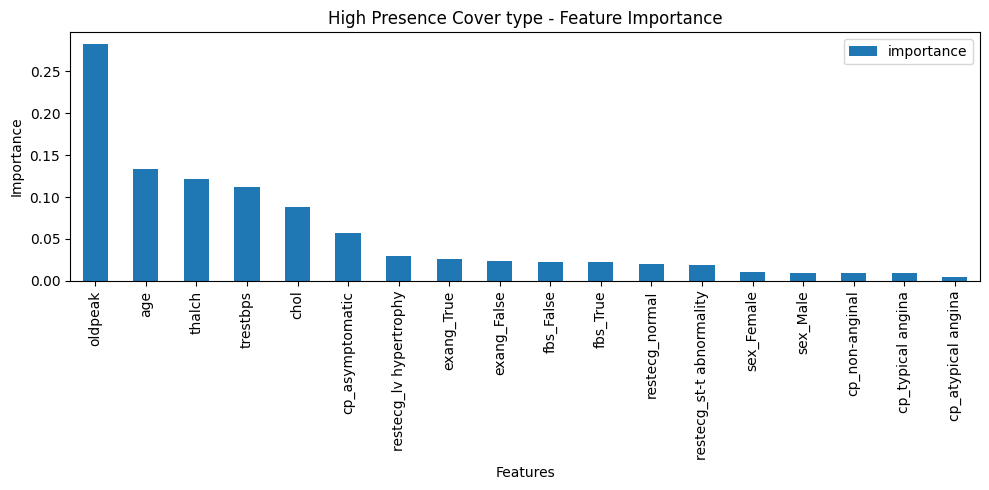

-----------------------------------------------------------------------------------------------




Processing CSV file: Moderate Presence.csv
Moderate Presence importance list:
Moderate Presence 
                           importance
Features                            
thalch                      0.146041
age                         0.132276
oldpeak                     0.114925
chol                        0.098961
exang_True                  0.093576
cp_asymptomatic             0.090906
trestbps                    0.077641
exang_False                 0.069387
fbs_True                    0.029876
fbs_False                   0.026683
cp_atypical angina          0.019198
sex_Male                    0.018092
restecg_normal              0.016129
sex_Female                  0.016000
restecg_lv hypertrophy      0.014856
cp_non-anginal              0.013977
restecg_st-t abnormality    0.013563
cp_typical angina           0.007913 



Moderate Presence=["thalch","age","oldpeak","chol","exang_

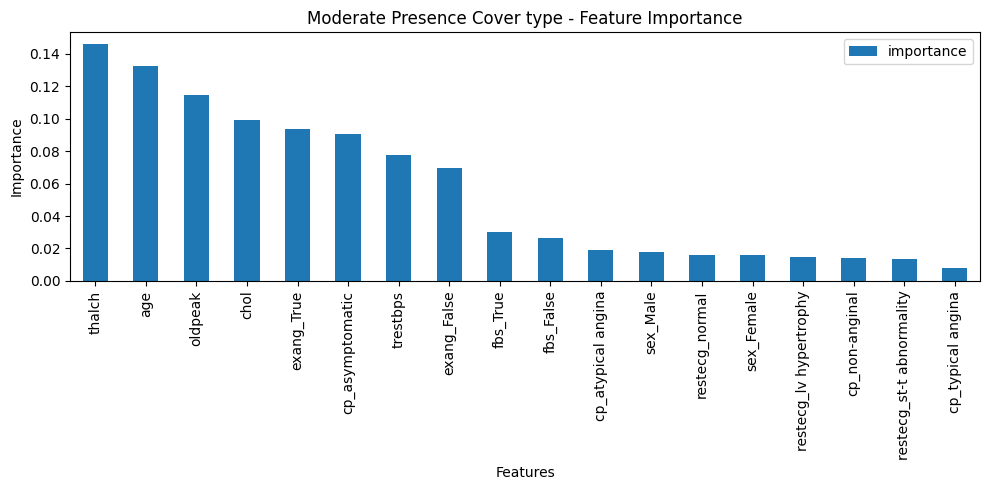

-----------------------------------------------------------------------------------------------




Processing CSV file: Slight Presence.csv
Slight Presence importance list:
Slight Presence 
                           importance
Features                            
thalch                      0.133046
chol                        0.126189
age                         0.115673
cp_asymptomatic             0.109211
trestbps                    0.105603
oldpeak                     0.092688
exang_True                  0.068560
exang_False                 0.053610
cp_atypical angina          0.028369
sex_Female                  0.024441
fbs_True                    0.022426
cp_non-anginal              0.021803
sex_Male                    0.018724
fbs_False                   0.018479
restecg_normal              0.018399
restecg_st-t abnormality    0.017798
restecg_lv hypertrophy      0.014287
cp_typical angina           0.010693 



Slight Presence=["thalch","chol","age","cp_asymptomatic","trestb

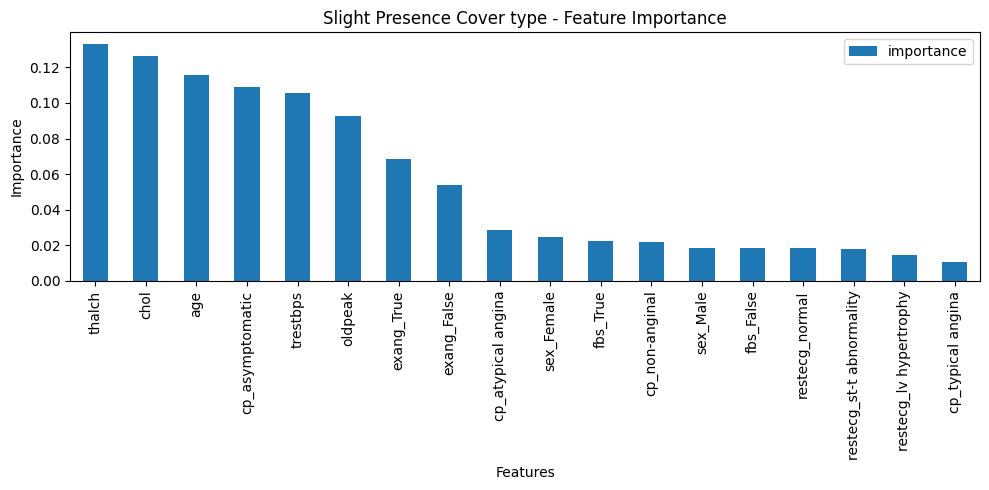

-----------------------------------------------------------------------------------------------




Processing CSV file: Presence.csv
Presence importance list:
Presence 
                           importance
Features                            
oldpeak                     0.146815
thalch                      0.130837
cp_asymptomatic             0.127255
age                         0.123343
chol                        0.106281
trestbps                    0.084222
exang_True                  0.047910
exang_False                 0.037691
fbs_True                    0.036282
fbs_False                   0.034657
sex_Female                  0.019350
restecg_normal              0.018401
cp_atypical angina          0.018300
restecg_st-t abnormality    0.017566
sex_Male                    0.016356
cp_non-anginal              0.014120
restecg_lv hypertrophy      0.013398
cp_typical angina           0.007217 



Presence=["oldpeak","thalch","cp_asymptomatic","age","chol"]


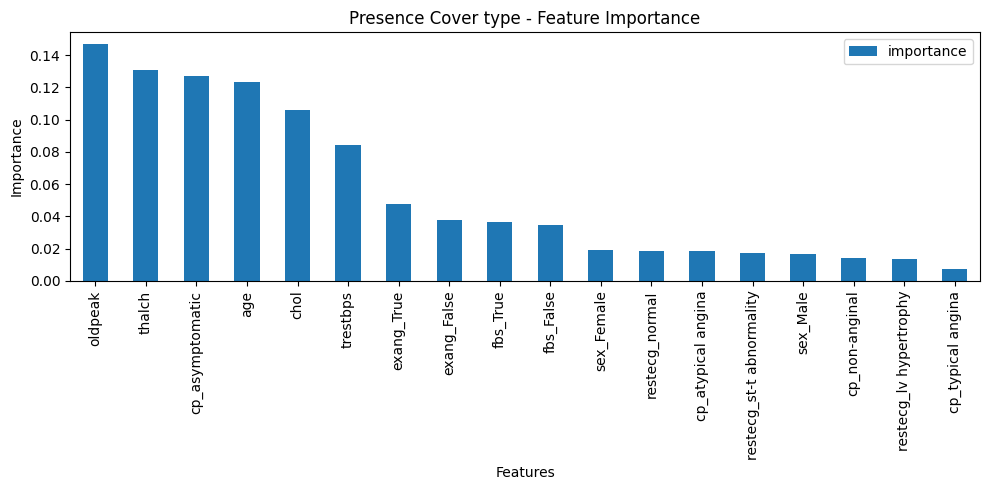

-----------------------------------------------------------------------------------------------




feature_importances: {'High Presence': ['oldpeak', 'age', 'thalch', 'trestbps', 'chol'], 'Moderate Presence': ['thalch', 'age', 'oldpeak', 'chol', 'exang_True'], 'Slight Presence': ['thalch', 'chol', 'age', 'cp_asymptomatic', 'trestbps'], 'Presence': ['oldpeak', 'thalch', 'cp_asymptomatic', 'age', 'chol']}
Total operation time: = 1.6291999816894531 seconds


In [26]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)
print('csv_files',csv_files)

feature_importances = {}
KNNs = {}

# Linear way
for csv in csv_files:
    label, important_features, knn, impor_bars = common.process_csv_with_args(csv, 
        main_labels=main_labels, 
        target_column=TARGET_COLUMN, 
        normal_target=NORMAL_TARGET, 
        numerical_columns=NUMERICAL_COLUMNS, 
        output_folder=OUTPUT_FOLDER,
        scaler=scaler)
    feature_importances[label] = important_features
    KNNs[label] = knn
    common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

# process_csv_with_args = partial(
#         common.process_csv, 
#         main_labels=main_labels, 
#         target_column=TARGET_COLUMN, 
#         normal_target=NORMAL_TARGET, 
#         numerical_columns=NUMERICAL_COLUMNS, 
#         output_folder=OUTPUT_FOLDER,
#         scaler=scaler 
#     )

# with ProcessPoolExecutor() as executor:
#         results = list(executor.map(process_csv_with_args, csv_files))

# # Collect results from the futures
# for label, important_features, svm, impor_bars in results:
#     feature_importances[label] = important_features
#     SVMs[label] = svm

#     # Show feature importance
#     common.show_feature_importance(impor_bars, label, FEATURE_FOLDER)
#     print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances:', feature_importances)
print("Total operation time: =", time.time() - seconds, "seconds")

In [27]:
seconds = time.time()

# Define the model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_df, y_train_df)

# # Define the parameter grid to search
# param_distributions = {
#     'n_estimators': [100, 200, 300, 400, 500],               # Number of trees
#     'max_depth': [None, 10, 20, 30, 40, 50],                 # Tree depth
#     'min_samples_split': [2, 5, 10],                         # Minimum samples to split a node
#     'min_samples_leaf': [1, 2, 4],                           # Minimum samples at a leaf
#     'max_features': ['auto', 'sqrt', 'log2'],                # Number of features to consider at each split
#     'bootstrap': [True, False]                               # Use bootstrap samples or not
# }

# # Perform random search with cross-validation
# random_search = RandomizedSearchCV(estimator=rf, 
#                                    param_distributions=param_distributions, 
#                                    n_iter=100,  # Number of parameter settings sampled
#                                    cv=3,        # 3-fold cross-validation
#                                    random_state=42, 
#                                    n_jobs=-1)   # Use all cores

# Fit the model
# random_search.fit(X_train_df, y_train_df)

# Best parameters found
# print("Best parameters found: ", random_search.best_params_)
# print("Best score: ", random_search.best_score_)

# Predict classes for the test set
test_predictions = rf.predict(X_test_df)
print('test_predictions', test_predictions)

print("Total operation time: = ", time.time() - seconds, "seconds")

test_predictions [1 0 0 0 2 2 0 0 1 0 3 1 0 1 3 0 3 0 1 1 0 3 1 0 2 0 1 0 1 0 3 0 1 0 1 1 0
 1 1 0 0 0 0 2 2 0 1 1 0 3 2 0 0 0 0 0 0 1 0 3 2 1 3 0 0 0 0 0 0 0 1 0 0 0
 1 0 1 0 1 0 3 0 0 1 1 1 0 1 0 0 0 0 1 0 3 0 0 0 1 0 1 1 2 2 0 1 0 0 0 0 1
 0 3 3 0 3 1 1 3 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 3 2 0 3 0 1 0 1 0 0 0
 0 0 2 0 1 2 0 1 3 0 2 1 0 0 0 3 0 0 0 0 1 2 0 1 0 1 1 0 0 0 0 0 1 1 2 0]
Total operation time: =  0.14289069175720215 seconds


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/brina/miniconda3/envs/gpu/lib/pyth

Best Tree's Decision Rules:
|--- exang_True <= 0.50
|   |--- cp_asymptomatic <= 0.50
|   |   |--- fbs_False <= 0.50
|   |   |   |--- age <= 55.50
|   |   |   |   |--- age <= 35.00
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- age >  35.00
|   |   |   |   |   |--- thalch <= 166.00
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- thalch >  166.00
|   |   |   |   |   |   |--- thalch <= 177.00
|   |   |   |   |   |   |   |--- cp_non-anginal <= 0.50
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- cp_non-anginal >  0.50
|   |   |   |   |   |   |   |   |--- trestbps <= 129.50
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- trestbps >  129.50
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- thalch >  177.00
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |--- age >  55.50
|   |   |   |   |--- chol <= 235.00
|   |   |   |   |   |--- thalch <= 136.00
|   | 

[Text(0.47360685071574643, 0.975, 'exang_True <= 0.5\ngini = 0.679\nsamples = 476\nvalue = [343, 202, 84, 82, 23]'),
 Text(0.21657719836400818, 0.925, 'cp_asymptomatic <= 0.5\ngini = 0.564\nsamples = 276\nvalue = [271, 81, 43, 28, 13]'),
 Text(0.07234151329243353, 0.875, 'fbs_False <= 0.5\ngini = 0.324\nsamples = 169\nvalue = [207, 31, 9, 6, 2]'),
 Text(0.022494887525562373, 0.825, 'age <= 55.5\ngini = 0.524\nsamples = 41\nvalue = [40, 14, 5, 3, 0]'),
 Text(0.0081799591002045, 0.775, 'age <= 35.0\ngini = 0.18\nsamples = 19\nvalue = [27, 3, 0, 0, 0]'),
 Text(0.00408997955010225, 0.725, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0, 0]'),
 Text(0.012269938650306749, 0.725, 'thalch <= 166.0\ngini = 0.128\nsamples = 18\nvalue = [27, 2, 0, 0, 0]'),
 Text(0.0081799591002045, 0.675, 'gini = 0.0\nsamples = 12\nvalue = [22, 0, 0, 0, 0]'),
 Text(0.016359918200409, 0.675, 'thalch <= 177.0\ngini = 0.408\nsamples = 6\nvalue = [5, 2, 0, 0, 0]'),
 Text(0.012269938650306749, 0.625, 'cp_non-anginal <= 

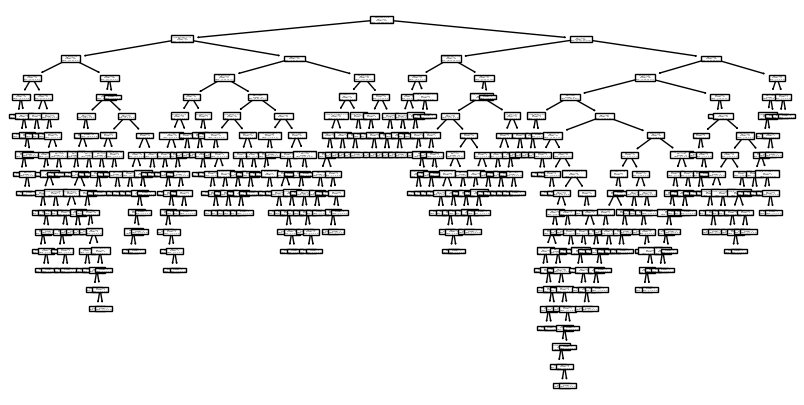

In [28]:
# Here we use out-of-bag score or use Gini Importance as criteria
best_tree_index = max(range(len(rf.estimators_)),
                      key=lambda i: rf.estimators_[i].score(X_train_df, y_train_df))
best_tree = rf.estimators_[best_tree_index]

feature_names = X_train_df.columns
tree_rules = export_text(best_tree, feature_names=feature_names)
print("Best Tree's Decision Rules:")
print(tree_rules)
plot_tree(best_tree, feature_names=feature_names)

# Step 4: Extract and print decision rules
# tree_rules = export_text(best_tree, feature_names=[f'feature_{i}' for i in range(X_train_df.shape[1])])
# print("Best Tree's Decision Rules:")
# print(tree_rules)

Multiclass Classification Evaluation


/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


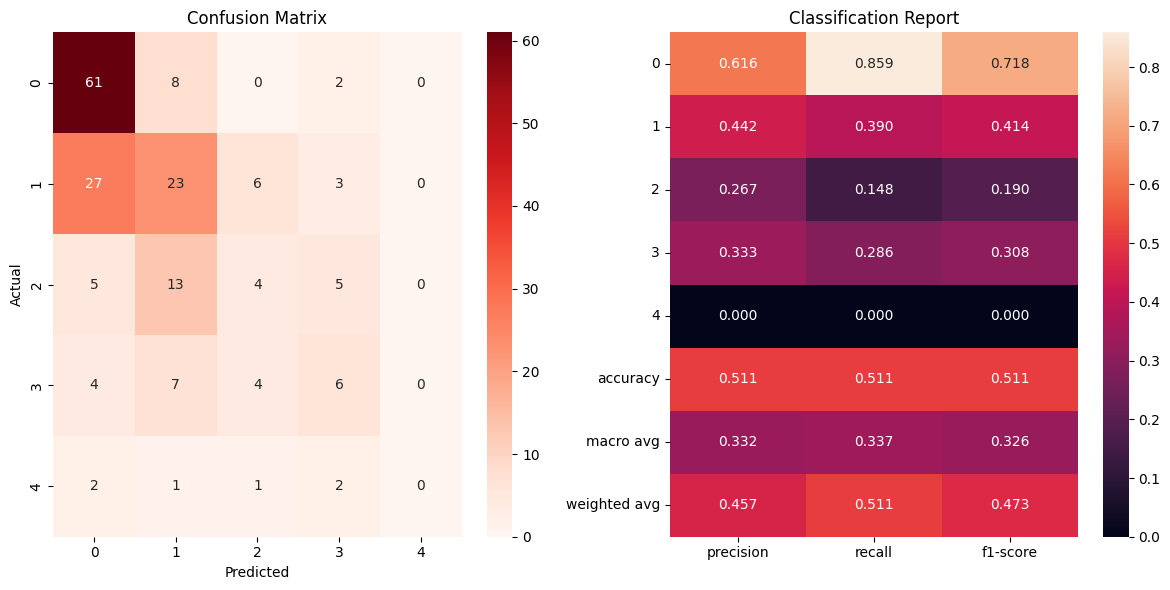

Accuracy: 0.5108695652173914


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.51087
f1-score_avg,0.47287
precision_avg,0.45676
recall_avg,0.51087


In [29]:
pn = "pipeline-" + project_name
wandb.init(project=pn, name="classification")
common.evaluate(y_test_df, test_predictions, heading='Multiclass Classification Evaluation')
wandb.finish()

In [30]:
seconds = time.time()
CONF_THRESHOLD = 0.95
improve_cnt = 0
deprove_cnt = 0

def predict_knn(predicted_label, test_instance_df):
    selected_features = feature_importances[predicted_label]
    knn_model = KNNs[predicted_label]
    # Select features for the KNN
    test_instance_selected_df = test_instance_df[selected_features]
    knn_prediction = knn_model.predict_proba(test_instance_selected_df)
    # print(knn_prediction)
    normal_class_prob = knn_prediction[:, 1]
    abnormal_class_prob = knn_prediction[:, 0]
    
    return (abnormal_class_prob, normal_class_prob)
    
def process_instance(i, test_instance_df):
    if test_predictions[i] == NORMAL_TARGET:
        max_prob = CONF_THRESHOLD
        final_class_1 = NORMAL_TARGET
        final_class_2 = final_class_1

        for key, knn in KNNs.items():
            sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
            if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
                max_prob = sub_abnormal_class_prob
                final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            status = 'NORMAL improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            status = 'NORMAL deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, max_prob)

    else:
        predicted_label = TARGET_DICT[test_predictions[i]]
        abnormal_class_prob, normal_class_prob = predict_knn(predicted_label, test_instance_df)
        max_prob = abnormal_class_prob if abnormal_class_prob > normal_class_prob else normal_class_prob
        final_class_1 = INV_TARGET_DICT[predicted_label] if abnormal_class_prob > normal_class_prob else NORMAL_TARGET
        final_class_2 = final_class_1

        if normal_class_prob > 1.0 - CONF_THRESHOLD and normal_class_prob < CONF_THRESHOLD:
            for key, knn in KNNs.items():
                if key != predicted_label:
                    sub_abnormal_class_prob, sub_normal_class_prob = predict_knn(key, test_instance_df)
                    if sub_abnormal_class_prob > sub_normal_class_prob and sub_abnormal_class_prob > max_prob:
                        max_prob = sub_abnormal_class_prob
                        final_class_2 = INV_TARGET_DICT[key]

        status = ''
        if final_class_1 != final_class_2 and final_class_2 == y_test_df.iloc[i]:
            # improve_cnt += 1
            status = 'improve'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, normal_class_prob, max_prob)
        if final_class_1 != final_class_2 and final_class_1 == y_test_df.iloc[i]:
            # deprove_cnt += 1
            status = 'deprove'
            print('final_class1', final_class_1, 'final_class2', final_class_2, 'actual', y_test_df.iloc[i], status, normal_class_prob, max_prob)
        # knn_predictions.append((final_class_2, y_test_df.iloc[i]))

    return i, final_class_2

# Run all test data instances in parallel and retain order
knn_predictions = [None] * len(X_test_scaled_df)  # Pre-allocate an array for ordered predictions

with ProcessPoolExecutor() as executor:
    futures = {executor.submit(process_instance, idx, X_test_scaled_df.iloc[idx].to_frame().T): idx for idx in range(len(X_test_scaled_df))}

    for future in as_completed(futures):
        idx, prediction = future.result()
        knn_predictions[idx] = prediction  # Insert each prediction at its respective index

# print('improve_cnt', improve_cnt, 'deprove_cnt', deprove_cnt)
print("Total operation time: = ", time.time() - seconds, "seconds")

final_class1final_class1  00  final_class2final_class2  final_class1final_class11 1 actual3 final_class1final_class1  actual 1  2 0  final_class21 NORMAL improve3final_class1  final_class2 final_class2 NORMAL improve2  [1.]  311
 final_class2 [1.] actual 
  2actual actual2 actual final_class1  1final_class2 0improve 11 2 final_class2     [0.16946679]3actualimproveimproveNORMAL improve     actual1[0.17953131][1.][0.22719554]  
  improve 3[1.][1.][1.] 


 [0.18779883]improve  [0.76834659][1.] 
[1.]
final_class1 1 final_class2 2 actual 2 improve [0.48041001] [1.]
final_class1 0 final_class2 3 actual 3 improve [0.69235724] [1.]
final_class1 0final_class1 final_class1 final_class2final_class1  104    final_class2final_class20actualfinal_class1     3140final_class2    3final_class2actualactual     final_class13actual NORMAL improve 11 2  improve 3 NORMAL improveactual[1.]
   final_class2 NORMAL improve1 [1.]  
1[0.2319194]final_class1NORMAL improve [1.]   [1.]actual[1.]
0
 final_class1 
fina

KNN Evaluation (overall)


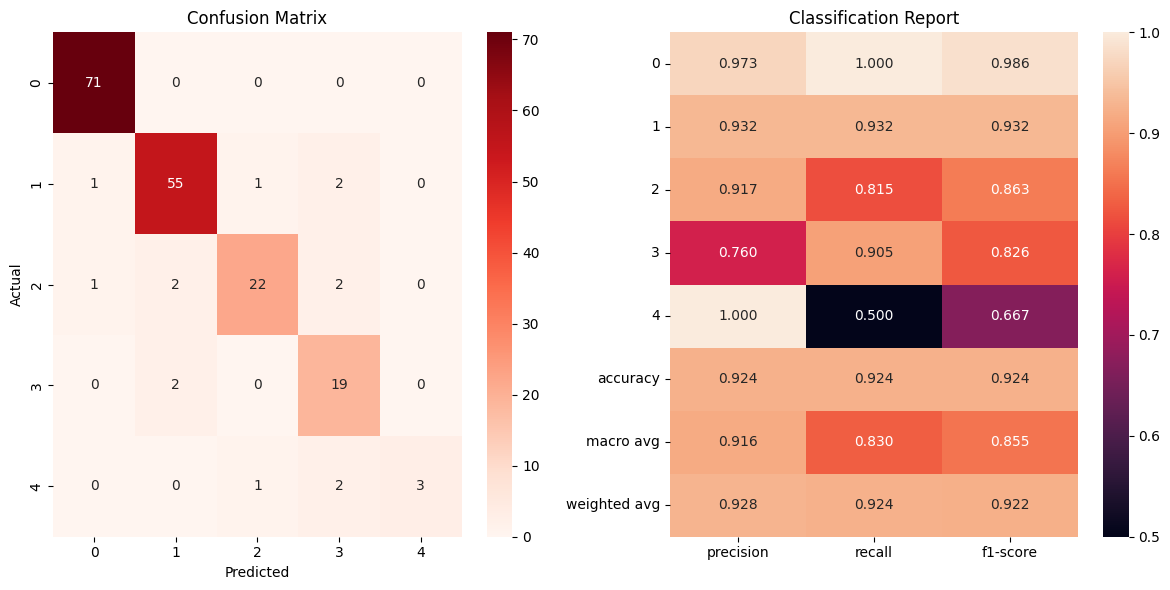

Accuracy: 0.9239130434782609


Accuracy Score,▁
f1-score_avg,▁
precision_avg,▁
recall_avg,▁
Accuracy Score,0.92391
f1-score_avg,0.92204
precision_avg,0.92807
recall_avg,0.92391


In [31]:
# Evaluate KNN on all test data
pn = "pipeline-" + project_name
wandb.init(project=pn, name="final-fullsample-knn-conf0.95")

# Modify the list and extract the second element in one step
# final_knn_predictions = [t[0] for t in knn_predictions] # New
# final_knn_predictions = [(lambda t: (t[0], NORMAL_TARGET, t[2]) if t[0] == 1 else t)(t)[1] for t in knn_predictions] # Old
final_knn_predictions_df = pd.DataFrame(knn_predictions, columns=[TARGET_COLUMN])
common.evaluate(y_test_df, final_knn_predictions_df, heading='KNN Evaluation (overall)')
wandb.finish()